## Task 1: COCO Dataset Preparation & Preprocessing

In [1]:
import kagglehub
import os
import numpy as np
import cv2
import json
from pycocotools.coco import COCO
from pycocotools import mask as maskUtils
from tqdm import tqdm
from PIL import Image

### 📥 Step 1: Download COCO 2017 Dataset

We downloaded the dataset using KaggleHub. The dataset includes:
- `train2017/` and `val2017/` image folders
- `annotations/` containing segmentation metadata in JSON format

The dataset path and structure were printed to verify successful setup.


In [2]:
# Download and print actual path
path = kagglehub.dataset_download("awsaf49/coco-2017-dataset")
print("✅ Dataset Path:", path)

# List contents inside it
import os
print("📁 Files:")
print(os.listdir(path))


✅ Dataset Path: /kaggle/input/coco-2017-dataset
📁 Files:
['coco2017']


### 🗂️ Step 2: Explore Dataset Structure

We walked through the folder to identify:
- Location of validation images: `val2017/`
- Annotations: `annotations/instances_val2017.json`

This helped us configure paths for further processing.


In [3]:
base_path = "/kaggle/input/coco-2017-dataset/coco2017"

for root, dirs, files in os.walk(base_path):
    for file in files:
        print(os.path.join(root, file))


Streaming output truncated to the last 5000 lines.
/kaggle/input/coco-2017-dataset/coco2017/train2017/000000421447.jpg
/kaggle/input/coco-2017-dataset/coco2017/train2017/000000368349.jpg
/kaggle/input/coco-2017-dataset/coco2017/train2017/000000520456.jpg
/kaggle/input/coco-2017-dataset/coco2017/train2017/000000213124.jpg
/kaggle/input/coco-2017-dataset/coco2017/train2017/000000116521.jpg
/kaggle/input/coco-2017-dataset/coco2017/train2017/000000319443.jpg
/kaggle/input/coco-2017-dataset/coco2017/train2017/000000481895.jpg
/kaggle/input/coco-2017-dataset/coco2017/train2017/000000564283.jpg
/kaggle/input/coco-2017-dataset/coco2017/train2017/000000266502.jpg
/kaggle/input/coco-2017-dataset/coco2017/train2017/000000117064.jpg
/kaggle/input/coco-2017-dataset/coco2017/train2017/000000207481.jpg
/kaggle/input/coco-2017-dataset/coco2017/train2017/000000237501.jpg
/kaggle/input/coco-2017-dataset/coco2017/train2017/000000023743.jpg
/kaggle/input/coco-2017-dataset/coco2017/train2017/000000548836.j

### 🧪 Step 3: Test Segmentation Mask Generation

We tested the segmentation mask generation pipeline by processing 100 images.

Each image was converted into a pixel-level mask where:
- Each class label (category) was mapped to a unique integer
- Masks were saved as `.png` files with the same filename as the original image


In [4]:
# Paths
ann_path = "/kaggle/input/coco-2017-dataset/coco2017/annotations/instances_val2017.json"
img_dir = "/kaggle/input/coco-2017-dataset/coco2017/val2017"
output_mask_dir = "/kaggle/working/masks"
os.makedirs(output_mask_dir, exist_ok=True)

# Load COCO
coco = COCO(ann_path)
img_ids = coco.getImgIds()
cat_ids = coco.getCatIds()
cat_id_to_idx = {cat_id: idx + 1 for idx, cat_id in enumerate(cat_ids)}  # start from 1

# Loop through images
for img_id in tqdm(img_ids[:100]):  # you can increase this number later
    img_info = coco.loadImgs(img_id)[0]
    file_name = img_info['file_name']
    width, height = img_info['width'], img_info['height']

    ann_ids = coco.getAnnIds(imgIds=img_id, iscrowd=False)
    anns = coco.loadAnns(ann_ids)

    mask = np.zeros((height, width), dtype=np.uint8)

    for ann in anns:
        cat_id = ann['category_id']
        cat_idx = cat_id_to_idx[cat_id]
        rle = coco.annToRLE(ann)
        ann_mask = maskUtils.decode(rle)
        mask[ann_mask == 1] = cat_idx

    # Save mask
    mask_path = os.path.join(output_mask_dir, file_name.replace(".jpg", ".png"))
    Image.fromarray(mask).save(mask_path)

loading annotations into memory...
Done (t=1.11s)
creating index...
index created!


100%|██████████| 100/100 [00:00<00:00, 129.72it/s]


### ⚠️ Step 4: Edge Case Handling

To ensure data quality, we handled common issues such as:
1. Missing or null segmentation fields
2. Zero-area annotations
3. Overlapping masks (handled by overwrite)
4. Invalid or unrecognized category IDs

These were skipped during mask creation to avoid errors and noise.


In [5]:
    for ann in anns:
        if 'segmentation' not in ann or ann['segmentation'] is None:
            continue  # Edge Case 1

        if ann['area'] == 0:
            continue  # Edge Case 2

        cat_id = ann['category_id']
        if cat_id not in cat_id_to_idx:
            continue  # Edge Case 4

        cat_idx = cat_id_to_idx[cat_id]
        rle = coco.annToRLE(ann)
        ann_mask = maskUtils.decode(rle)

        mask[ann_mask == 1] = cat_idx  # Edge Case 3: overlaps handled


### 💾 Step 5: Process Full Dataset and Save Metadata

We processed 3,000 images and created corresponding segmentation masks.

In addition:
- A category-to-index map was saved in `category_mapping.json`
- A file-to-mask mapping was saved in `image_mask_map.json`
- All masks were saved in the `masks/` directory under the Kaggle working folder

This completes Task 1 – Dataset Preparation.


In [6]:
# Save category mapping
with open("/kaggle/working/category_mapping.json", "w") as f:
    json.dump(cat_id_to_idx, f, indent=2)

# Save image-mask mapping
image_mask_map = {}

# Process 3,000 images
for img_id in tqdm(img_ids[:3000]):
    img_info = coco.loadImgs(img_id)[0]
    file_name = img_info['file_name']
    width, height = img_info['width'], img_info['height']

    ann_ids = coco.getAnnIds(imgIds=img_id, iscrowd=False)
    anns = coco.loadAnns(ann_ids)

    mask = np.zeros((height, width), dtype=np.uint8)

    for ann in anns:
        if 'segmentation' not in ann or ann['segmentation'] is None:
            continue
        if ann['area'] == 0:
            continue
        cat_id = ann['category_id']
        if cat_id not in cat_id_to_idx:
            continue

        cat_idx = cat_id_to_idx[cat_id]
        rle = coco.annToRLE(ann)
        ann_mask = maskUtils.decode(rle)
        mask[ann_mask == 1] = cat_idx

    mask_filename = file_name.replace(".jpg", ".png")
    Image.fromarray(mask).save(os.path.join(output_mask_dir, mask_filename))
    image_mask_map[file_name] = mask_filename

# Save mapping file
with open("/kaggle/working/image_mask_map.json", "w") as f:
    json.dump(image_mask_map, f, indent=2)

print("✅ Step 4 complete: Saved 3000 masks, mapping files.")

100%|██████████| 3000/3000 [00:24<00:00, 121.31it/s]

✅ Step 4 complete: Saved 3000 masks, mapping files.


## Task 2: COCO Image Segmentation Model

In [7]:
import os
import json
import numpy as np
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [8]:
IMAGE_DIR = "/kaggle/input/coco-2017-dataset/coco2017"
MASK_DIR = "/kaggle/working/masks"
IMG_MASK_MAP = "/kaggle/working/image_mask_map.json"


### Step 1: Model Setup and Training for Multi-Class Segmentation

#### 📦 Custom Dataset Class: `CocoSegmentationDataset`

This class loads COCO images and their corresponding segmentation masks. It:

- Uses a JSON mapping of image-to-mask file names.
- Resizes both images and masks to 256×256.
- Converts images to tensors and masks to LongTensor labels for training.

The masks retain integer values representing class labels.


In [33]:
class CocoSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, img_mask_map_path, transform=None):
        # Load mapping between image file and corresponding mask file
        with open(img_mask_map_path, 'r') as f:
            self.img_mask_map = json.load(f)
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = list(self.img_mask_map.keys())  # List of image filenames

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Get image and corresponding mask filenames
        img_name = self.images[idx]
        mask_name = self.img_mask_map[img_name]

        # Load image and mask
        image = Image.open(os.path.join(self.image_dir, img_name)).convert("RGB")
        mask = Image.open(os.path.join(self.mask_dir, mask_name))

        # Resize both to 128x128 (common size for training)
        image = image.resize((256, 256))
        mask = mask.resize((256, 256), resample=Image.NEAREST)

        # Convert image to tensor and normalize [0,1]
        image = transforms.ToTensor()(image)

        # Convert mask (PIL image) to tensor (LongTensor for class indices)
        mask = torch.from_numpy(np.array(mask)).long()

        return image, mask

#### 🔄 Dataset Preparation and DataLoader Setup

This block handles the loading and preparation of the dataset for training and validation:

- **Transformations**:  
  Images are resized to 256×256 and converted to PyTorch tensors.

- **Dataset Initialization**:  
  A custom `CocoSegmentationDataset` is initialized with image and mask paths, along with a JSON file that maps images to their corresponding masks.

- **Train-Validation Split**:  
  The dataset is randomly split into:
  - 80% training samples
  - 20% validation samples

- **DataLoaders**:  
  - `train_loader` is used during training and includes shuffling for randomness.
  - `val_loader` is used for evaluation without shuffling to preserve order.


In [34]:
# Define transformations for the image (resize + tensor conversion)
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Initialize dataset with image and mask paths + mapping
dataset = CocoSegmentationDataset(
    image_dir=os.path.join(IMAGE_DIR, "val2017"),
    mask_dir=MASK_DIR,
    img_mask_map_path=IMG_MASK_MAP,
    transform=transform
)

# Split dataset into training (80%) and validation (20%)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2)


#### 🖼️ Visualize a Sample Image and its Segmentation Mask

We visualize a sample from the training loader to verify the image-mask pair alignment.

- Left: RGB input image
- Right: Corresponding multi-class segmentation mask


Image shape: torch.Size([4, 3, 256, 256])
Mask shape: torch.Size([4, 256, 256])


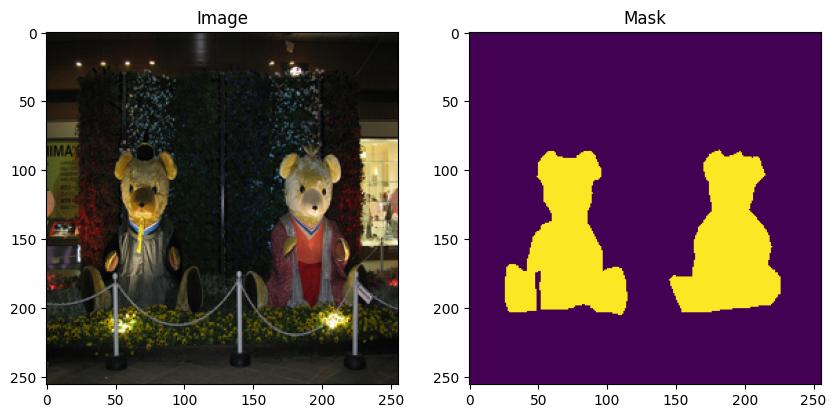

In [36]:
# Load one batch of data
images, masks = next(iter(train_loader))
print("Image shape:", images.shape)  # Expected: [B, 3, 256, 256]
print("Mask shape:", masks.shape)    # Expected: [B, 256, 256]

# Plot the first image and its corresponding mask
plt.figure(figsize=(10, 5))

# Display RGB image
plt.subplot(1, 2, 1)
plt.imshow(transforms.ToPILImage()(images[0]))
plt.title("Image")

# Display segmentation mask
plt.subplot(1, 2, 2)
plt.imshow(masks[0])
plt.title("Mask")
plt.show()


###Step 2: Demonstrate generalization on unseen data

#### 🔹 1. Load Pretrained DeepLabV3

We load a DeepLabV3 model with a ResNet-50 backbone, pretrained on the COCO dataset.  
The final classifier layer is modified to output 81 channels — one for each COCO class (80) plus background.  
Finally, we move the model to the available computation device (GPU if available).


In [37]:
import torchvision.models.segmentation as models
import torch.nn as nn

# Load DeepLabV3 with a ResNet-50 backbone, pretrained on COCO
model = models.deeplabv3_resnet50(pretrained=True)

# Replace the classifier head to match number of classes in our dataset
# Assuming 80 COCO classes + 1 background = 81 output channels
model.classifier[4] = nn.Conv2d(256, 81, kernel_size=1)

# Move the model to GPU if available
model = model.to(device)


#### 🔹 2. Define Loss Function & Optimizer

We use:
- `CrossEntropyLoss` for multi-class segmentation where each pixel is classified into one of the classes.
- `Adam` optimizer with a learning rate of 1e-4 to fine-tune the pretrained model weights.


In [38]:
import torch.optim as optim

# Use CrossEntropyLoss which is suitable for multi-class pixel-wise classification
criterion = nn.CrossEntropyLoss()

# Adam optimizer with a low learning rate for fine-tuning
optimizer = optim.Adam(model.parameters(), lr=1e-4)


#### 🔹 3. Training Loop (Single Epoch)

This function runs the model for one training epoch:

- Enables training mode
- For each batch:
  - Moves images and masks to device
  - Performs forward pass
  - Calculates loss
  - Backpropagates gradients
  - Updates weights
- Returns average loss over all batches


In [39]:
def train_one_epoch(loader):
    model.train()
    running_loss = 0.0

    for images, masks in tqdm(loader):
        # Move data to GPU
        images, masks = images.to(device), masks.to(device)

        # Forward pass
        outputs = model(images)['out']  # Get segmentation output

        # Compute loss
        loss = criterion(outputs, masks)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Return average loss over all batches
    return running_loss / len(loader)


#### 🔹 4. Validation Accuracy Function

This function evaluates the model on the validation set:

- Disables gradient computation for faster inference
- Predicts the segmentation map for each image
- Calculates pixel-wise accuracy across the entire validation set
- Returns accuracy as a percentage


In [40]:
def evaluate(loader):
    model.eval()
    total_pixels, correct_pixels = 0, 0

    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)

            # Get predicted output and take argmax across channel dimension
            outputs = model(images)['out']
            preds = torch.argmax(outputs, dim=1)

            # Compare predicted vs actual mask
            correct_pixels += (preds == masks).sum().item()
            total_pixels += torch.numel(masks)

    # Return pixel-wise accuracy
    return 100 * correct_pixels / total_pixels


#### 🔹 5. Run Training for Few Epochs & Evaluate Generalization

We train the model for a few epochs and evaluate its performance after each one.  
This helps monitor both:
- Training loss
- Validation accuracy

It demonstrates how well the model generalizes to unseen data.


In [41]:
for epoch in range(5):
    train_loss = train_one_epoch(train_loader)
    val_accuracy = evaluate(val_loader)
    print(f"Epoch {epoch+1}: Loss = {train_loss:.4f}, Val Accuracy = {val_accuracy:.2f}%")


100%|██████████| 600/600 [03:30<00:00,  2.85it/s]


Epoch 1: Loss = 2.0013, Val Accuracy = 77.31%


100%|██████████| 600/600 [03:32<00:00,  2.83it/s]


Epoch 2: Loss = 1.1461, Val Accuracy = 77.59%


100%|██████████| 600/600 [03:31<00:00,  2.83it/s]


Epoch 3: Loss = 1.0024, Val Accuracy = 78.71%


100%|██████████| 600/600 [03:32<00:00,  2.83it/s]


Epoch 4: Loss = 0.9008, Val Accuracy = 80.39%


100%|██████████| 600/600 [03:32<00:00,  2.83it/s]


Epoch 5: Loss = 0.8183, Val Accuracy = 79.90%


#### 🔹 6. Visualize Predictions vs Ground Truth

We visualize:
- The input image
- The true segmentation mask
- The predicted segmentation mask

This qualitative evaluation helps verify that the model learns spatial class boundaries correctly.


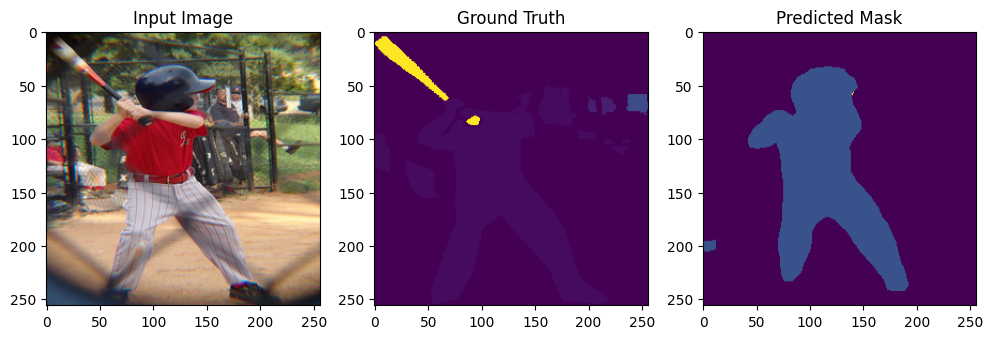

In [42]:
# Set model to evaluation mode
model.eval()

# Take a batch from the validation set
images, masks = next(iter(val_loader))
images = images.to(device)

with torch.no_grad():
    outputs = model(images)['out']
    preds = torch.argmax(outputs, dim=1).cpu()  # Get predicted classes

# Plot first image from the batch
plt.figure(figsize=(12, 6))

# Original input image
plt.subplot(1, 3, 1)
plt.imshow(transforms.ToPILImage()(images[0].cpu()))
plt.title("Input Image")

# Ground truth mask
plt.subplot(1, 3, 2)
plt.imshow(masks[0])
plt.title("Ground Truth")

# Predicted mask
plt.subplot(1, 3, 3)
plt.imshow(preds[0])
plt.title("Predicted Mask")

plt.show()
